In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

RESULTS_DIR = Path("results")
REG_FILE = RESULTS_DIR / "regression_data.csv"

print("Loading:", REG_FILE)
df_reg = pd.read_csv(REG_FILE)
df_reg.head()

Loading: results/regression_data.csv


,episode,a1,reward,common,agent_type,volatility,seed,prev_a1,prev_reward,prev_common,stay,prev_reward_bin,prev_common_bin
0,1,0,0.0,1,hybrid,0.015,0,0.0,1.0,1.0,1,1,1
1,2,0,1.0,0,hybrid,0.015,0,0.0,0.0,1.0,1,0,1
2,3,1,1.0,1,hybrid,0.015,0,0.0,1.0,0.0,0,1,0
3,4,1,1.0,1,hybrid,0.015,0,1.0,1.0,1.0,1,1,1
4,5,0,1.0,1,hybrid,0.015,0,1.0,1.0,1.0,0,1,1


In [3]:
print(df_reg.columns)
print()
print(df_reg[[
    "agent_type", "volatility", "seed",
    "prev_reward_bin", "prev_common_bin", "stay"
]].head())

Index(['episode', 'a1', 'reward', 'common', 'agent_type', 'volatility', 'seed',
       'prev_a1', 'prev_reward', 'prev_common', 'stay', 'prev_reward_bin',
       'prev_common_bin'],
      dtype='object')

  agent_type  volatility  seed  prev_reward_bin  prev_common_bin  stay
0     hybrid       0.015     0                1                1     1
1     hybrid       0.015     0                0                1     1
2     hybrid       0.015     0                1                0     0
3     hybrid       0.015     0                1                1     1
4     hybrid       0.015     0                1                1     0


In [5]:
group_seed = (
    df_reg
    .groupby(
        ["agent_type", "volatility", "seed",
         "prev_reward_bin", "prev_common_bin"]
    )["stay"]
    .mean()
    .reset_index(name="stay_prob")
)

group_seed.head()

,agent_type,volatility,seed,prev_reward_bin,prev_common_bin,stay_prob
0,hybrid,0.015,0,0,0,0.496732
1,hybrid,0.015,0,0,1,0.555556
2,hybrid,0.015,0,1,0,0.525180
3,hybrid,0.015,0,1,1,0.558989
4,hybrid,0.015,1,0,0,0.509934


In [7]:
summary = (
    group_seed
    .groupby(
        ["agent_type", "volatility", "prev_reward_bin", "prev_common_bin"]
    )["stay_prob"]
    .agg(["mean", "std", "count"])
    .reset_index()
)

summary["se"] = summary["std"] / np.sqrt(summary["count"])
summary.head()

,agent_type,volatility,prev_reward_bin,prev_common_bin,mean,std,count,se
0,hybrid,0.015,0,0,0.521735,0.052661,20,0.011775
1,hybrid,0.015,0,1,0.488948,0.027887,20,0.006236
2,hybrid,0.015,1,0,0.493551,0.044852,20,0.010029
3,hybrid,0.015,1,1,0.517356,0.028963,20,0.006476
4,hybrid,0.025,0,0,0.512329,0.044490,20,0.009948


In [9]:
def condition_label(r, c):
    
    return f"R={int(r)}, C={int(c)}"

def plot_agent_stay_vs_vol(agent, save_dir=None):
    
    sub = summary[summary["agent_type"] == agent].copy()
    if sub.empty:
        print(f"[WARN] No data for agent_type = {agent}")
        return

    sub = sub.sort_values("volatility")
    vol_values = sorted(sub["volatility"].unique())

    conds = (
        sub[["prev_reward_bin", "prev_common_bin"]]
        .drop_duplicates()
        .itertuples(index=False, name=None)
    )

    fig, ax = plt.subplots(figsize=(8, 5))

    for r, c in conds:
        mask = ((sub["prev_reward_bin"] == r) &
                (sub["prev_common_bin"] == c))
        d = sub[mask].sort_values("volatility")

        ax.errorbar(
            d["volatility"],
            d["mean"],
            yerr=d["se"],
            marker="o",
            linestyle="-",
            capsize=3,
            label=condition_label(r, c),
        )

    ax.set_title(f"Stay probability vs volatility (agent = {agent})")
    ax.set_xlabel("Volatility σ (drift_std)")
    ax.set_ylabel("Stay probability")
    ax.grid(True, alpha=0.3)
    ax.legend(title="Previous trial")

    plt.tight_layout()

    if save_dir is not None:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)
        out_path = save_dir / f"stayprob_vs_vol_{agent}.png"
        fig.savefig(out_path, dpi=200)
        print("Saved:", out_path)

    return fig, ax

Saved: figs_new/stayprob_vs_vol_hybrid.png
Saved: figs_new/stayprob_vs_vol_mb.png
Saved: figs_new/stayprob_vs_vol_mf.png


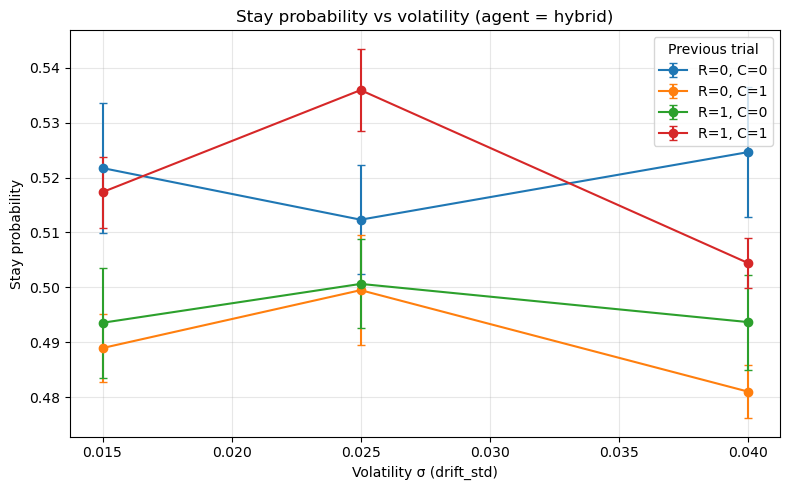

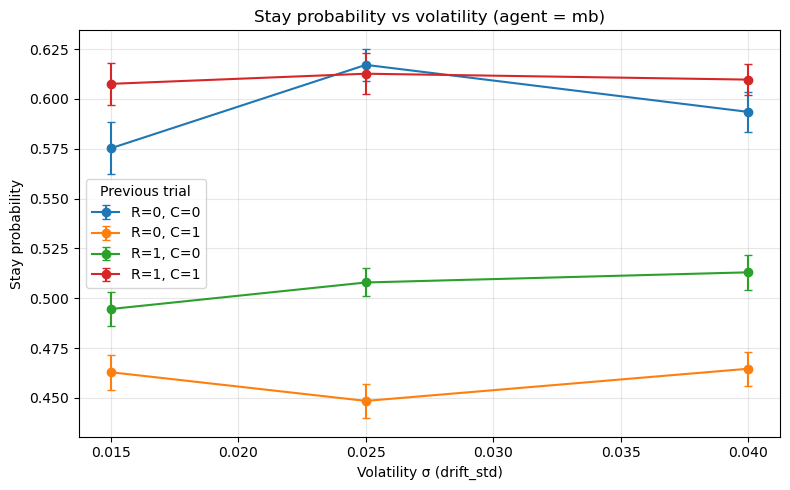

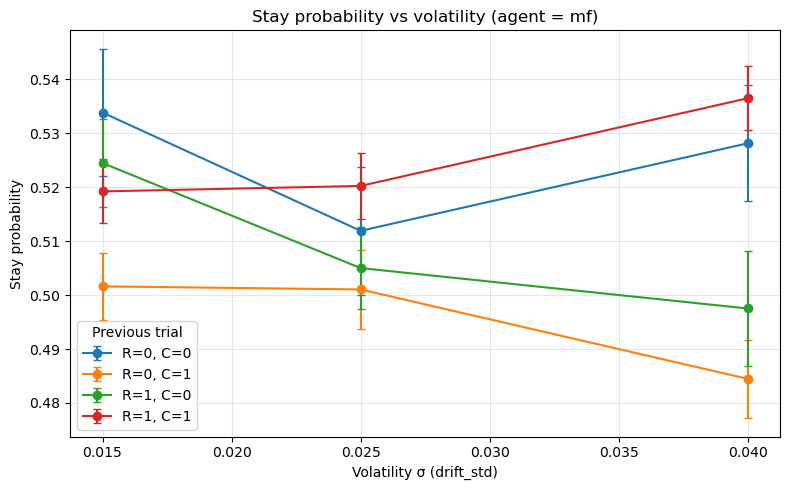

In [11]:
OUTPUT_FIG_DIR = Path("figs_new")

for agent in sorted(df_reg["agent_type"].unique()):
    plot_agent_stay_vs_vol(agent, save_dir=OUTPUT_FIG_DIR)